# TP 3 : Méthode Physic-Informed Neural Network

In [1]:
import torch

In [2]:
def rejection_sampling(nb_data, phi, bounds=[[-1.0, 1.0], [-1.0, 1.0]]):
    data = []
    while len(data) < nb_data:
        x = torch.rand((nb_data, 2))
        x[:, 0] = x[:, 0] * (bounds[0][1] - bounds[0][0]) + bounds[0][0]
        x[:, 1] = x[:, 1] * (bounds[1][1] - bounds[1][0]) + bounds[1][0]
        mask = phi(x) < 0
        selected = x[mask]
        data.append(selected)
    data = torch.cat(data, dim=0)[:nb_data] 
    return data

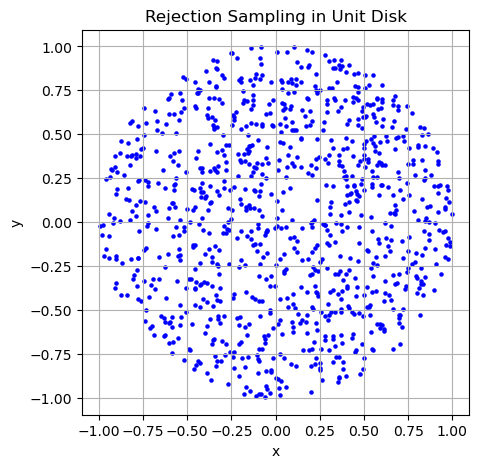

In [3]:
import matplotlib.pyplot as plt

def phi_unit_disk(x):
    return x[:, 0]**2 + x[:, 1]**2 - 1.0

def test_rejection_sampling():
    x = rejection_sampling(1000, phi_unit_disk)
    x = x.detach().numpy()
    plt.figure(figsize=(5, 5))
    plt.scatter(x[:, 0], x[:, 1], s=5, c='blue')
    plt.title("Rejection Sampling in Unit Disk")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

test_rejection_sampling()

In [4]:
def make_collocation_points(nb_collocation, phi, mu_range=[0.1, 1.0], bounds=[[-1.0, 1.0], [-1.0, 1.0]]):
    x_collocation = rejection_sampling(nb_collocation, phi, bounds=bounds)
    
    mu_collocation = torch.rand((nb_collocation, 1), dtype=torch.double)
    mu_collocation = mu_collocation * (mu_range[1] - mu_range[0]) + mu_range[0]

    return x_collocation, mu_collocation

In [5]:
class mlp(torch.nn.Module):
    def __init__(self, layer_widths = list):
        super().__init__()

        self.layer_widths = layer_widths
        
        self.hidden_layers = []
        for i in range( len(layer_widths)-1):
            self.hidden_layers.append(torch.nn.Linear(self.layer_widths[i], self.layer_widths[i+1], dtype=torch.double))

        self.hidden_layers = torch.nn.ModuleList(self.hidden_layers)
        self.activation = torch.nn.Tanh()

    def forward(self, inputs):
        for i in range(len(self.layer_widths) - 1):
                inputs = self.activation(self.hidden_layers[i].forward(inputs))
        return inputs

In [6]:
class Pinn_poisson:
    def __init__(self, dim_x, dim_mu, phi, f, g, layer_widths, lr=1e-3):
        self.dim_x = dim_x
        self.dim_mu = dim_mu
        self.phi = phi
        self.f = f
        self.g = g
        
        self.network = mlp(layer_widths)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=lr)

    def train(self, nb_collocation, nb_epochs, mu_range=[0.1, 1.0], bounds=[[-1.0, 1.0], [-1.0, 1.0]]):

        self.network.train()
        for epoch in range(nb_epochs):
            self.optimizer.zero_grad()

            x_colloc, mu_colloc = make_collocation_points(nb_collocation, self.phi, mu_range=mu_range, bounds=bounds)
            
            x_colloc.requires_grad_(True)
            
            inputs = torch.cat([x_colloc, mu_colloc], dim=1)
            
            phi_x = self.phi(x_colloc).unsqueeze(1)   # shape: (N, 1)
            g_val = self.g(x_colloc, mu_colloc)
            net_out = self.network(inputs)

            u_pred = g_val * (1 + phi_x) + phi_x * net_out

            grad_u = torch.autograd.grad(u_pred.sum(), x_colloc, create_graph=True)[0]
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]

            u_xx = torch.autograd.grad(u_x.sum(), x_colloc, create_graph=True)[0][:, 0]
            u_yy = torch.autograd.grad(u_y.sum(), x_colloc, create_graph=True)[0][:, 1]
            
            residual = - (u_xx + u_yy) - self.f(x_colloc, mu_colloc).squeeze()

            loss = torch.mean(residual ** 2)
        
            loss.backward()
            self.optimizer.step()
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}")
        

In [7]:
def phi_unit_disk(x):
    return x[:, 0]**2 + x[:, 1]**2 - 1
def f_func(x, mu):
    r2 = x[:, 0]**2 + x[:, 1]**2
    mu_val = mu[:, 0]
    return (1 / (2 * torch.pi * mu_val**2)) * torch.exp(-r2 / (2 * mu_val**2))
def g_func(x, mu):
    return torch.zeros((x.shape[0], 1), dtype=torch.double)
def test_pinns_poisson():
    layer_widths = [3, 20, 20, 20, 1]

    pinn = Pinn_poisson(
        dim_x=2,
        dim_mu=1,
        phi=phi_unit_disk,
        f=f_func,
        g=g_func,
        layer_widths=layer_widths,
        lr=1e-3
    )
    
    nb_collocation = 1000
    nb_epochs = 200

    pinn.train(nb_collocation, nb_epochs)

test_pinns_poisson()


Epoch 0, Loss: 0.1871630106900816
Epoch 10, Loss: 0.37270662536066673
Epoch 20, Loss: 0.23536905452563228
Epoch 30, Loss: 0.19093334114591962
Epoch 40, Loss: 0.1929367991688763
Epoch 50, Loss: 0.1265825659784481
Epoch 60, Loss: 0.1171883142748408
Epoch 70, Loss: 0.16244629252500775
Epoch 80, Loss: 0.17750940509699226
Epoch 90, Loss: 0.15170745650627906
Epoch 100, Loss: 0.16678166111679119
Epoch 110, Loss: 0.05880606981446868
Epoch 120, Loss: 0.13502281807840408
Epoch 130, Loss: 0.16388118547805422
Epoch 140, Loss: 0.09495500829179443
Epoch 150, Loss: 0.14501525784505817
Epoch 160, Loss: 0.06943392461858403
Epoch 170, Loss: 0.1259037424644334
Epoch 180, Loss: 0.09990784013507806
Epoch 190, Loss: 0.17162690648867976
